In [1]:
import pycigar
import pandas as pd
import numpy as np
from pycigar.tutorials.custom_input_parser import input_parser

In [2]:
from pycigar.utils.registry import register_devcon
#from pycigar.controllers.custom_adaptive_inverter_controller import CustomAdaptiveInverterController
from pycigar.controllers.MRAC_adaptive_controller import MRAC_adaptive_controller
from pycigar.controllers.adaptive_inverter_controller import AdaptiveInverterController
from pycigar.controllers.custom_hack_controller import CustomHackController
from pycigar.controllers.fixed_controller import FixedController

from pycigar.devices.direct_power_injection_device_new import DirectPowerInjectionDevice

In [3]:
register_devcon('Attacker', CustomHackController)
#register_devcon('Defender', CustomAdaptiveInverterController)
register_devcon('Defender', MRAC_adaptive_controller)
register_devcon('custom_pv_device', DirectPowerInjectionDevice)
#register_devcon('custom_pv_device', CustomPVDevice)



'custom_pv_device'

In [4]:
file_misc_inputs_path = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None, names=['parameter', 'value'])
misc_inputs.value['hack start']=250
misc_inputs.value['hack end']=2000
misc_inputs.value['hack update']=4000
misc_inputs.value['measurement filter time constant mean']=1
misc_inputs.value['measurement filter time constant avg v']=10
misc_inputs.value['gamma']=20   #control=1
misc_inputs.value['k']=0
misc_inputs.value['epsilon']=1e-7
#misc_inputs.Value['solar scaling factor']=1.5
misc_inputs.to_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', header=None)

hack=0.2

In [5]:
misc_inputs = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
dss = pycigar.DATA_DIR + '/ieee37busdata/ieee37.dss'
load_solar = pycigar.DATA_DIR + '/ieee37busdata/load_solar_data.csv'
breakpoints = pycigar.DATA_DIR + '/ieee37busdata/breakpoints.csv'

sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, percentage_hack=hack, vectorized_mode=False)
start = 100
sim_params['scenario_config']['start_end_time'] = [start, start + 1500]  # fix the exp start and end time
sim_params['env_config']['sims_per_step'] = 1 # on 1 step call, it is equal to 1 simulation step.
del sim_params['attack_randomization'] # turn off the attack randomization

from pycigar.envs.norl_env import NoRLEnv
env = NoRLEnv(sim_params=sim_params) # init env with the sim_params above

env.reset()
done = False
while not done:
    done = env.step() # every step call will return done, the status whether the exp is finished or not

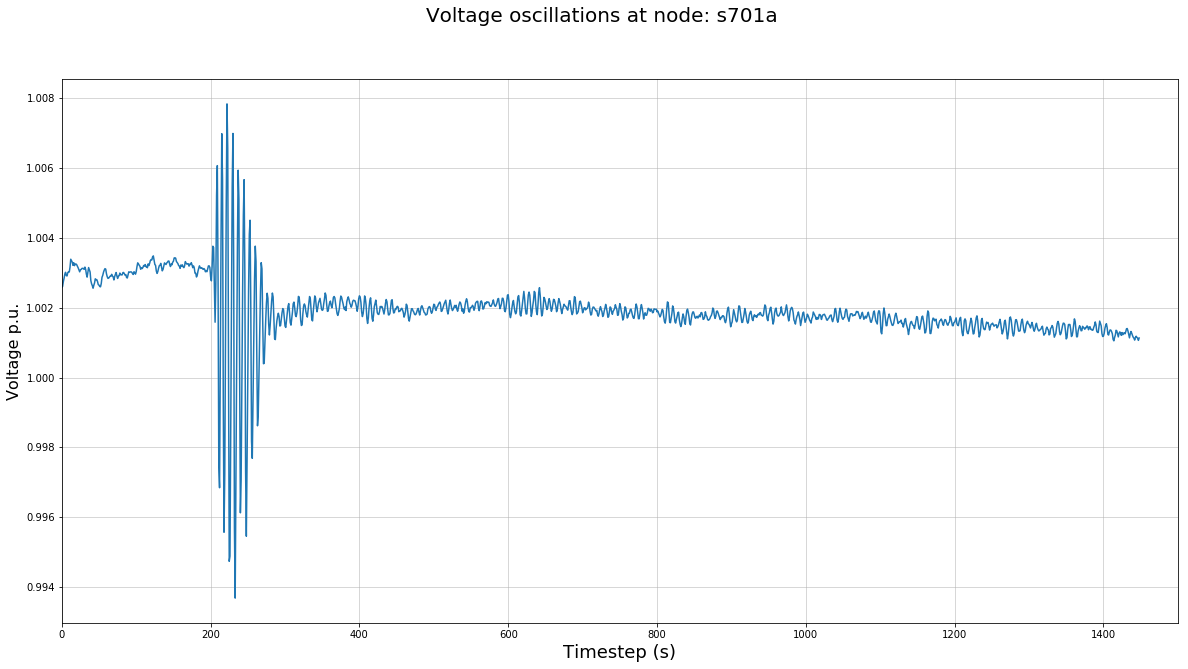

In [6]:
from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
plt.show()

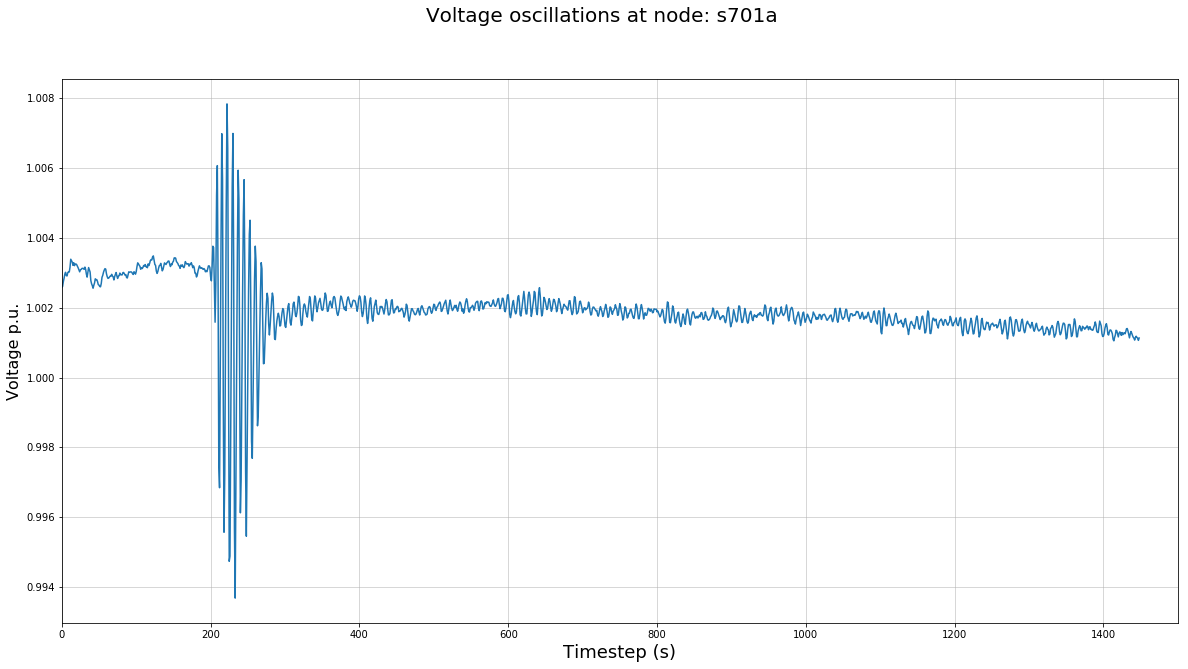

In [7]:
from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
plt.savefig("direct_power_inj.png")
plt.show()



In [8]:
node_id = 's701a'
xmax = 600
voltage_csv = np.asarray(Logger.log_dict[node_id]['voltage'][0:xmax]).reshape(-1,1)
time_vec = np.arange(0,xmax).reshape(-1,1)
time_voltages = np.concatenate((time_vec, voltage_csv), axis=1)
df = pd.DataFrame(time_voltages, columns=['Time', 'Voltage'])

#df.to_csv("direct_pow_voltage" + node_id + "_control.csv")
#df.to_csv("direct_pow_voltage" + node_id + "_no_control.csv")

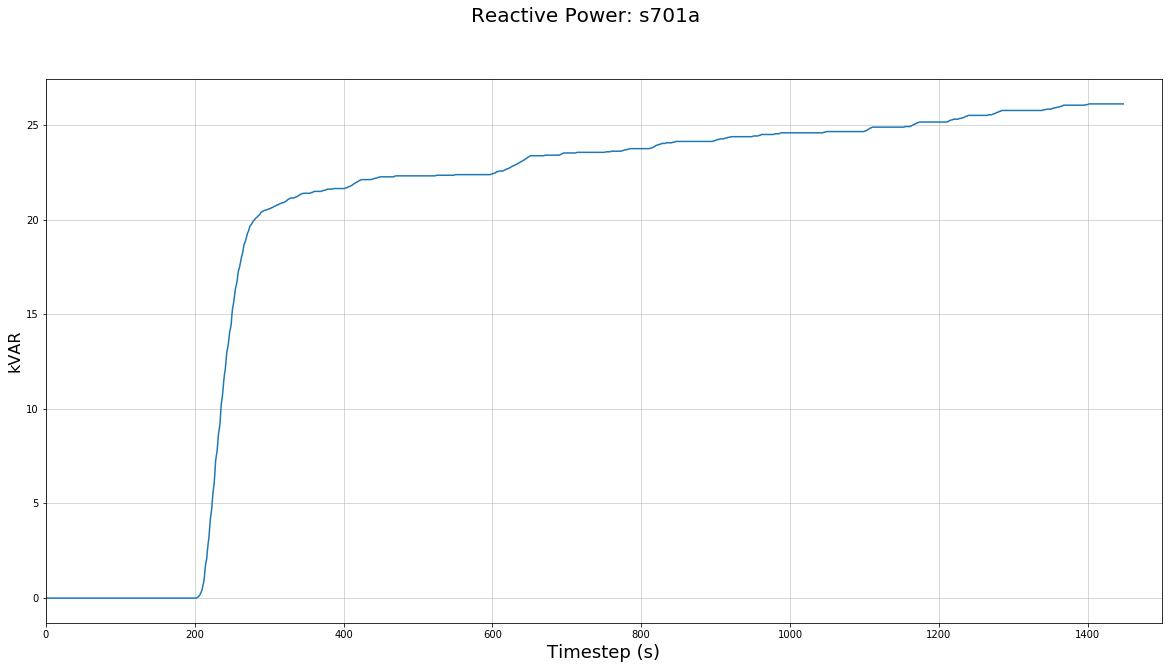

In [9]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
key = 'inverter_s701a'
f.suptitle('Reactive Power: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('kVAR', fontsize=16)
ax.plot(Logger.log_dict[key]['q_inj'])
plt.savefig('direct_power_injection_q.png')
plt.show()

In [10]:
Logger.log_dict[key].keys()

dict_keys(['y', 'voltage_state', 'q_bar', 'u', 'p_set', 'q_set', 'p_out', 'q_out', 'control_setting', 'sbar_solarirr', 'sbar_pset', 'solar_irr', 'node', 'q_inj'])